In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import dash
from dash import dcc,html
import warnings
warnings.filterwarnings('ignore')
import joblib

In [3]:
df = pd.read_csv('FoodPanda.csv')
df.head(10)

,customer_id,gender,age,city,signup_date,order_id,order_date,restaurant_name,dish_name,category,quantity,price,payment_method,order_frequency,last_order_date,loyalty_points,churned,rating,rating_date,delivery_status
0,C5663,Male,Adult,Peshawar,1/14/2024,O9663,8/23/2023,McDonald's,Burger,Italian,5,1478.27,Cash,38,7/19/2025,238,Active,3,10/14/2024,Cancelled
1,C2831,Male,Adult,Multan,7/7/2024,O6831,8/23/2023,KFC,Burger,Italian,3,956.04,Wallet,24,11/25/2024,81,Active,2,8/21/2025,Delayed
2,C2851,Other,Senior,Multan,6/20/2025,O6851,8/23/2023,Pizza Hut,Fries,Italian,2,882.51,Cash,42,5/10/2025,82,Inactive,3,9/19/2024,Delayed
3,C1694,Female,Senior,Peshawar,9/5/2023,O5694,8/23/2023,Subway,Pizza,Dessert,4,231.30,Card,27,7/24/2025,45,Inactive,2,6/29/2025,Delayed
4,C4339,Other,Senior,Lahore,12/29/2023,O8339,8/24/2023,KFC,Sandwich,Dessert,1,1156.69,Cash,35,12/21/2024,418,Inactive,3,3/6/2025,Cancelled
5,C6543,Other,Adult,Karachi,9/28/2023,O10543,8/24/2023,Burger King,Pizza,Fast Food,5,1213.62,Cash,45,10/10/2024,418,Inactive,4,6/1/2025,Delivered
6,C6423,Male,Adult,Lahore,4/8/2025,O10423,8/24/2023,McDonald's,Pasta,Continental,5,672.91,Wallet,31,5/25/2025,347,Active,1,3/4/2025,Cancelled
7,C4621,Male,Adult,Peshawar,2/5/2024,O8621,8/24/2023,Pizza Hut,Pizza,Chinese,2,271.74,Cash,14,5/1/2025,429,Active,2,9/30/2024,Delivered
8,C5146,Other,Senior,Karachi,12/17/2024,O9146,8/24/2023,KFC,Pizza,Dessert,5,596.96,Wallet,1,5/16/2025,24,Active,4,10/27/2024,Delayed
9,C3579,Male,Adult,Karachi,10/13/2023,O7579,8/24/2023,Pizza Hut,Pizza,Continental,2,1443.25,Cash,15,2/23/2025,270,Inactive,3,10/11/2024,Delayed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      6000 non-null   object 
 1   gender           6000 non-null   object 
 2   age              6000 non-null   object 
 3   city             6000 non-null   object 
 4   signup_date      6000 non-null   object 
 5   order_id         6000 non-null   object 
 6   order_date       6000 non-null   object 
 7   restaurant_name  6000 non-null   object 
 8   dish_name        6000 non-null   object 
 9   category         6000 non-null   object 
 10  quantity         6000 non-null   int64  
 11  price            6000 non-null   float64
 12  payment_method   6000 non-null   object 
 13  order_frequency  6000 non-null   int64  
 14  last_order_date  6000 non-null   object 
 15  loyalty_points   6000 non-null   int64  
 16  churned          6000 non-null   object 
 17  rating        

In [5]:
df.shape

(6000, 20)

In [6]:
df.describe()

,quantity,price,order_frequency,loyalty_points,rating
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,2.991667,800.524880,25.304667,250.173667,2.996833
std,1.414778,404.855029,14.358930,144.608478,1.406113
min,1.000000,100.300000,1.000000,0.000000,1.000000
25%,2.000000,441.997500,13.000000,125.000000,2.000000
50%,3.000000,806.460000,25.000000,249.500000,3.000000
75%,4.000000,1149.737500,37.000000,378.000000,4.000000
max,5.000000,1499.950000,50.000000,500.000000,5.000000


In [7]:
df['churned'] = (df['churned'] == 'Inactive').astype(int)
cols_to_drop = [
    'customer_id', 'order_id', 'signup_date', 'order_date',
    'last_order_date', 'restaurant_name', 'dish_name', 'rating_date'
]
df = df.drop(cols_to_drop, axis=1)

In [8]:
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [9]:
X = df.drop('churned', axis=1)
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_score = rf.score(X_test_scaled, y_test)
print(f'RandomForest Test Accuracy: {rf_score:.2f}')

RandomForest Test Accuracy: 0.51


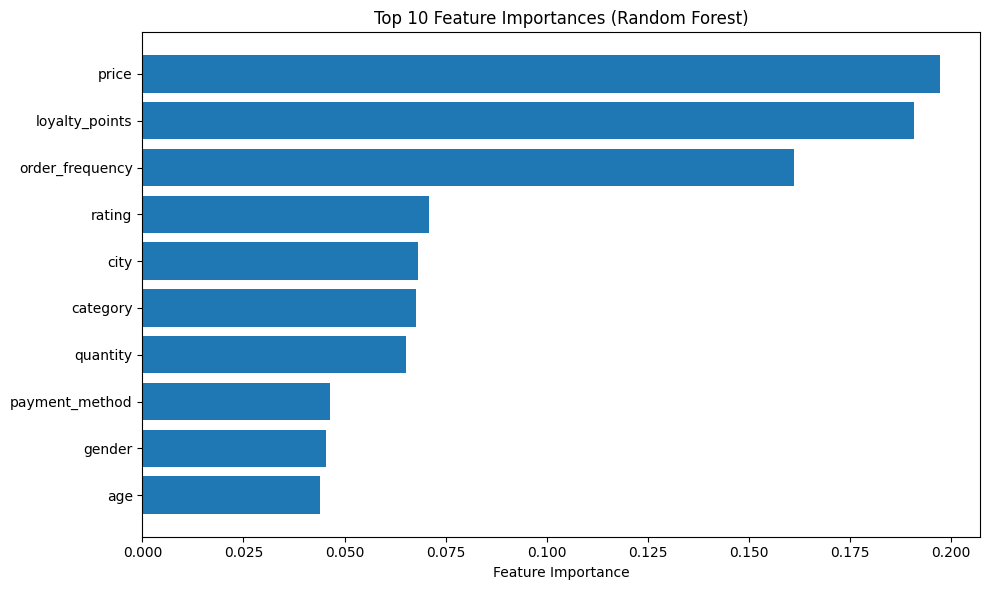

In [11]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_features.index[::-1], top_features.values[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.savefig('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

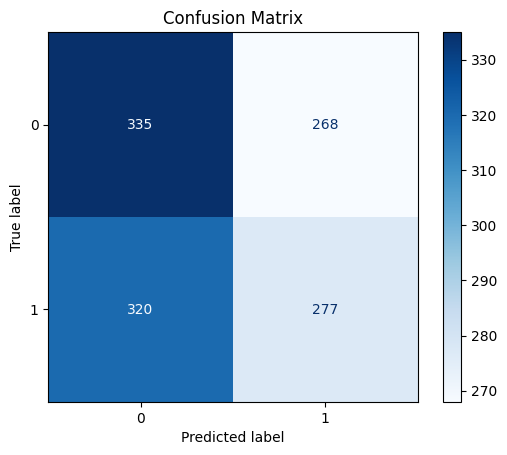

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix')
plt.show()

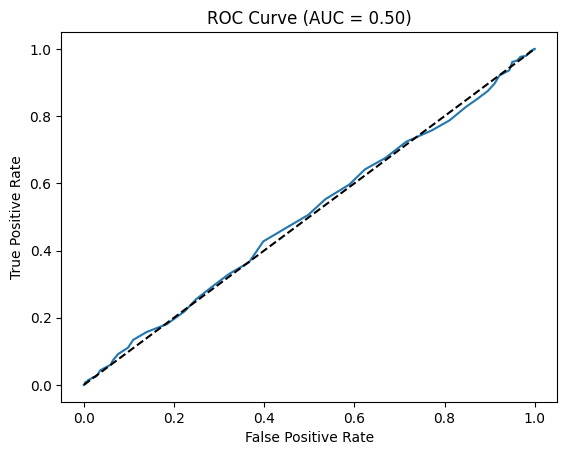

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.2f})')
plt.savefig('ROC Curve')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('RandomForest Test Accuracy: {:.2f}'.format(rf_score))
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Active', 'Inactive']))

print('Top 10 Features:', top_features)

print(df[['city', 'churned']].groupby('city').mean().sort_values('churned', ascending=False))


RandomForest Test Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

      Active       0.51      0.56      0.53       603
    Inactive       0.51      0.46      0.49       597

    accuracy                           0.51      1200
   macro avg       0.51      0.51      0.51      1200
weighted avg       0.51      0.51      0.51      1200

Top 10 Features: price              0.197241
loyalty_points     0.190662
order_frequency    0.161002
rating             0.070920
city               0.068191
category           0.067663
quantity           0.065158
payment_method     0.046362
gender             0.045384
age                0.043866
dtype: float64
       churned
city          
2     0.518488
3     0.515924
0     0.492839
4     0.478661
1     0.478603


In [20]:
import dice_ml
from dice_ml.utils import helpers
data_dice = dice_ml.Data(
    dataframe=df,
    continuous_features=['price','order_frequency','loyalty_points','quantity','rating'],
    outcome_name='churned'
)
model_dice = dice_ml.Model(model=rf, backend='sklearn')
exp = dice_ml.Dice(data_dice, model_dice)
cf = exp.generate_counterfactuals(X_test.iloc[[0]], total_CFs=3, desired_class=0)  # 0: Active
cf.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00, 18.54it/s]

Query instance (original outcome : 1)


,gender,age,city,category,quantity,price,payment_method,order_frequency,loyalty_points,rating,delivery_status,churned
0,0,2,4,4,3,1078.170044,1,37,178,3,2,1



Diverse Counterfactual set (new outcome: 0)


,gender,age,city,category,quantity,price,payment_method,order_frequency,loyalty_points,rating,delivery_status,churned
0,0,2,4,4,3,1078.17,0,37,469,3,2,0
1,0,0,4,4,3,1078.17,1,37,178,3,2,0
2,0,0,4,4,3,1078.17,1,37,178,3,2,0


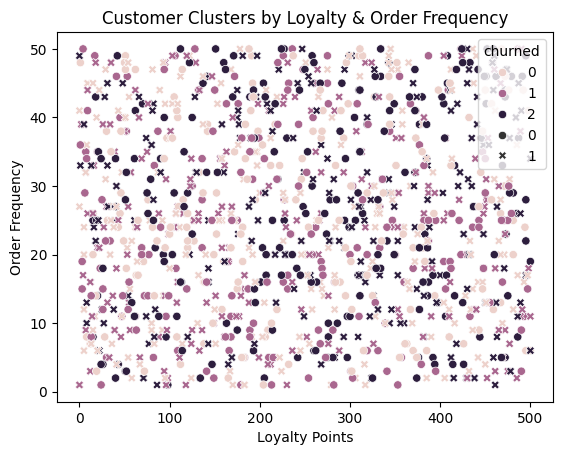

In [26]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3, random_state=42).fit_predict(X_test_scaled)
import seaborn as sns

sns.scatterplot(x=X_test['loyalty_points'], y=X_test['order_frequency'], hue=clusters, style=y_test)
plt.title('Customer Clusters by Loyalty & Order Frequency')
plt.xlabel('Loyalty Points')
plt.ylabel('Order Frequency')
plt.savefig('Customer Clusters by Loyalty & Order Frequency')
plt.show()

In [28]:
df.columns.to_list()

['gender',
 'age',
 'city',
 'category',
 'quantity',
 'price',
 'payment_method',
 'order_frequency',
 'loyalty_points',
 'churned',
 'rating',
 'delivery_status']